In [1]:
#Importing libraries
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F


/usr/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
#Images files folder
path = 'archive'
data_dir = 'archive/natural_images'


In [4]:
#Normalizing, rotating and flipping the images by transforming using pytorch methods.
transformer = torchvision.transforms.Compose(
    [ # Applying Augmentation
        torchvision.transforms.Resize((144,144 )),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(10),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2]
        ),
    ]
)
database = ImageFolder(data_dir, transform=transformer)

In [5]:
#Setting the validation size
validation_size = 500
training_size = len(database) - validation_size

In [6]:
#Splitting data in test and train dataset
trainset, testset = random_split(database, [training_size, validation_size])

In [7]:
#Initializing batch size and creating list of batches in train and test datasets
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [8]:
#Total classes or types of flowers
database.classes

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']

In [9]:
classes = ('airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


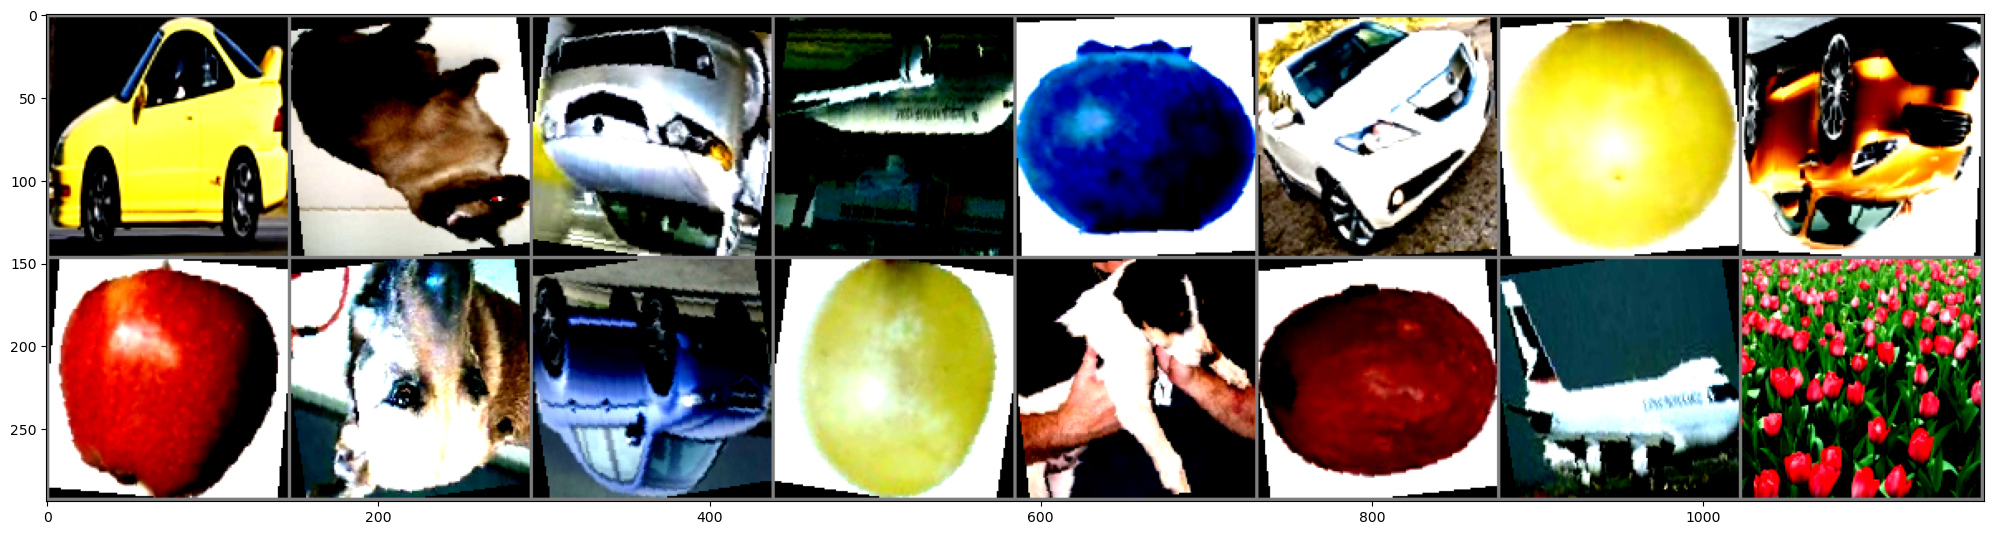

car   cat   car   airplane fruit car   fruit car   fruit dog   car   fruit dog   fruit airplane flower


In [10]:
#Showing 16 random images from a single random batch in a grid format
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(25, 25))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(iter(trainloader))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
#Creating the model with 3 convultional layers and 3 pooling layers, 1 fully connected layers.
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=53, kernel_size=4, stride=2, padding=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(53, 106, kernel_size=4, stride=2, padding=3)
        self.conv3 = nn.Conv2d(106, 212, kernel_size=4, stride=2, padding=3)
        self.fc1 = nn.Linear(212*3*3, 1908)
        self.fc2 = nn.Linear(1908, 8)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net().to(device)

In [12]:
import torch.optim as optim
#Initializing learning rate and beta value ; creating optimizer
criterion = nn.CrossEntropyLoss()
lr_dynamic = 0.01
momentum_dynamic = 0.9
optimizer = optim.SGD(net.parameters(), lr=lr_dynamic, momentum=momentum_dynamic)


In [13]:
#Initializing lists for plotting the graphs of epoch vs loss
Epoch_list =[]
Loss_list =[]
for epoch in range(50):  # loop over the dataset multiple times
    if epoch >= 10:
      if sum(Loss_list[-5:]) > sum(Loss_list[-10:-5]):
        break
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move inputs and labels to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            if i==99:
              Epoch_list.append((epoch) + 0.25)
              Loss_list.append(running_loss)
            if i==199:
              Epoch_list.append((epoch) + 0.5)
              Loss_list.append(running_loss)
            if i==299:
              Epoch_list.append((epoch) + 0.75)
              Loss_list.append(running_loss)
            if i==399:
              Epoch_list.append((epoch) + 1)
              Loss_list.append(running_loss)

            running_loss = 0.0
            #Adjusting the learning rate for every approx half epoch with decay rate of 0.96
            lr_dynamic = 0.96*lr_dynamic
            optimizer = optim.SGD(net.parameters(), lr=lr_dynamic, momentum=momentum_dynamic) 


print('Finished Training')

[1,   100] loss: 1.672
[1,   200] loss: 1.161
[1,   300] loss: 0.862
[1,   400] loss: 0.723
[2,   100] loss: 0.609
[2,   200] loss: 0.537
[2,   300] loss: 0.530
[2,   400] loss: 0.466
[3,   100] loss: 0.463
[3,   200] loss: 0.403
[3,   300] loss: 0.402
[3,   400] loss: 0.382
[4,   100] loss: 0.360
[4,   200] loss: 0.336
[4,   300] loss: 0.339
[4,   400] loss: 0.328
[5,   100] loss: 0.270
[5,   200] loss: 0.290
[5,   300] loss: 0.304
[5,   400] loss: 0.270
[6,   100] loss: 0.231
[6,   200] loss: 0.264
[6,   300] loss: 0.236
[6,   400] loss: 0.227
[7,   100] loss: 0.222
[7,   200] loss: 0.196
[7,   300] loss: 0.203
[7,   400] loss: 0.202
[8,   100] loss: 0.185
[8,   200] loss: 0.175
[8,   300] loss: 0.183
[8,   400] loss: 0.181
[9,   100] loss: 0.172
[9,   200] loss: 0.163
[9,   300] loss: 0.156
[9,   400] loss: 0.162
[10,   100] loss: 0.172
[10,   200] loss: 0.136
[10,   300] loss: 0.133
[10,   400] loss: 0.153
[11,   100] loss: 0.124
[11,   200] loss: 0.137
[11,   300] loss: 0.134
[11,

<Axes: xlabel='Batch-Epoch'>

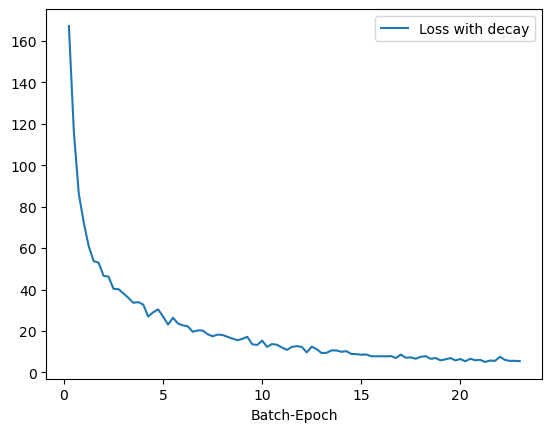

In [14]:
#Plotting the graphs epoch vs loss
loss_df = pd.DataFrame(data={'Batch-Epoch': Epoch_list, 
                        'Loss with decay': Loss_list})
fig, ax = plt.subplots() # Create the figure and axes object

loss_df.plot(x = 'Batch-Epoch', y = 'Loss with decay', ax = ax) 

In [15]:
#Saving the model
path_net = path + r'/model.pth'
torch.save(net.state_dict(), path_net)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


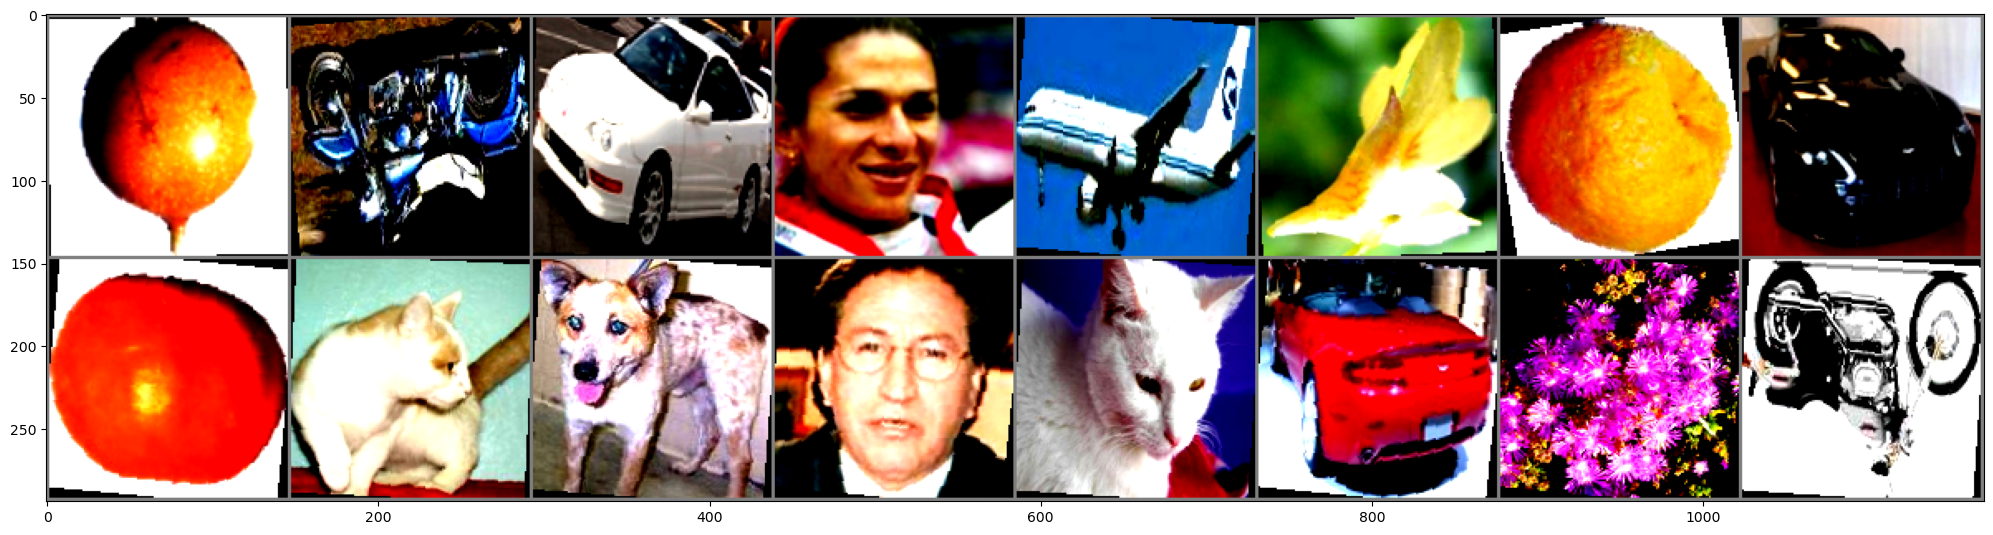

GroundTruth:  fruit motorbike car   person airplane flower fruit car   fruit cat   dog   person cat   car   flower motorbike


In [16]:
#Showing 16 sample images of test dataset
dataiter = iter(testloader)
images, labels = next(iter(trainloader))

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

In [17]:
#Sample testing on model
net = Net()
net.load_state_dict(torch.load(path_net))

<All keys matched successfully>

In [18]:
outputs = net(images)

In [19]:
#Sample predictions
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(16)))

Predicted:  fruit motorbike car   person airplane flower fruit car   fruit cat   dog   person cat   car   flower motorbike


In [20]:
#Series and dataframes to store actual and predicted values.
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images: {100 * correct // total} %')

Accuracy of the network on the train images: 98 %


In [21]:
#Series and dataframes to store actual and predicted values.
test_results = pd.DataFrame(columns = ['Actual_Image','Predicted_Image'])
Actual_Image= pd.Series(name='Actual_Image',dtype = str)
Predicted_Image= pd.Series(name='Predicted_Image',dtype = str)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        Actual_Image = pd.concat([Actual_Image, pd.Series(labels.tolist(), name='Actual_Image')], ignore_index=True)
        Predicted_Image = pd.concat([Predicted_Image, pd.Series(predicted.tolist(), name='Predicted_Image')], ignore_index=True)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 500 test images: {100 * correct // total} %')


Accuracy of the network on the 500 test images: 94 %


In [22]:
#Creating the test results dataframe
test_results = pd.concat([Actual_Image,Predicted_Image], axis = 1)

test_results['Actual_Image']    = test_results['Actual_Image'].map({0:'airplane',1: 'car',2: 'cat', 3: 'dog', 4:'flower', 5:'fruit', 6:'motorbike',7: 'person'})
test_results['Predicted_Image'] = test_results['Predicted_Image'].map({0:'airplane',1: 'car',2: 'cat', 3: 'dog', 4:'flower', 5:'fruit', 6:'motorbike',7: 'person'})
display(test_results)

,Actual_Image,Predicted_Image
0,car,car
1,car,car
2,cat,cat
3,car,car
4,flower,flower
...,...,...
495,fruit,fruit
496,motorbike,motorbike
497,fruit,fruit
498,cat,cat


In [23]:
#Printing the metrics like confution matrix of final model prediction and also classification report.
print("Confusion matrix with true and predicted counts of each flower with ID:")
display(pd.crosstab(test_results['Actual_Image'].squeeze(), test_results['Predicted_Image'].squeeze(), rownames=['True'], colnames=['Predicted'], margins=True))

Confusion matrix with true and predicted counts of each flower with ID:


Predicted,airplane,car,cat,dog,flower,fruit,motorbike,person,All
True,,,,,,,,,
airplane,44,1,0,1,0,0,0,0,46
car,0,69,0,2,0,0,0,0,71
cat,1,0,44,8,0,0,0,0,53
dog,0,0,7,47,3,0,0,0,57
flower,0,0,1,1,69,0,0,0,71
fruit,0,0,0,0,0,80,0,0,80
motorbike,1,1,1,0,0,0,51,0,54
person,0,0,1,0,0,0,0,67,68
All,46,71,54,59,72,80,51,67,500


# =============== testing ===============

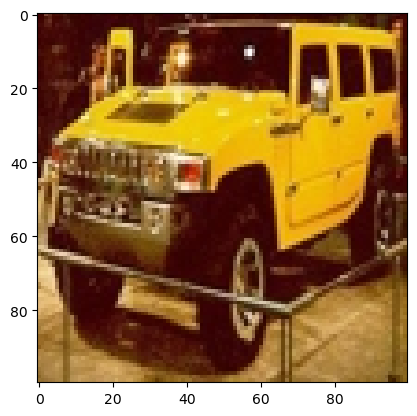

/usr/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.11/tkinter/__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "/home/hqnw/.local/lib/python3.11/site-packages/customtkinter/windows/widgets/ctk_button.py", line 554, in _clicked
    self._command()
  File "/tmp/ipykernel_605088/596392874.py", line 77, in <lambda>
    b1 = ctk.CTkButton(win,text='Upload \nPhoto', width=20,command = lambda:upload_file())
                                                                            ^^^^^^^^^^^^^
  File "/tmp/ipykernel_605088/596392874.py", line 67, in upload_file
    get_probabilities(img)
  File "/tmp/ipykernel_605088/596392874.py", line 49, in get_probabilities
    text.delete

[[5.5950060e-02 9.9900993e+01 8.3768788e-07 1.1578785e-04 4.1729867e-02
  3.0350662e-08 1.2047928e-03 7.2205769e-11]]


In [24]:
import tkinter as tk
from tkinter import filedialog  # noqa: F811
from PIL import Image, ImageTk  # noqa: F811
from tkinter import Label, Text, Scrollbar, Frame
from torch.autograd import Variable  # noqa: F811
from tkinter import *

from PIL import Image  # noqa: F811
from torch.autograd import Variable  # noqa: F811

import customtkinter as ctk

ctk.set_appearance_mode("dark")

win = ctk.CTk()
win.geometry("1200x1000")
win.configure(fg_color="#2E3440")


font1 = ('times', 12, 'bold')
text = Text(win, height=8, width=25)

myscrollbar=Scrollbar(text)
text.configure(yscrollcommand=myscrollbar.set)
text.grid(row=0, column=0, padx=20, pady=10)
text.config(font=font1)

font1 = ('times',15, 'bold')
predict = Text(win,bg="#4C566A", height=1, width=20)
predict.grid(row=1, column=3, padx=20, pady=10)
predict.config(font=font1)


frame = Frame(win, width=500, height=400, bg="white", colormap="new")
frame.grid(row=0, column=3, padx=20, pady=10)

def get_probabilities(image):  # noqa: F811
  imgplot = plt.imshow(image)  # noqa: F841
  plt.show()
  image = transformer(image)
  image = image.float()
  image = Variable(image, requires_grad=True)
  image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
  outputs = net(image)
  _, predicted = torch.max(outputs.data, 1)
  sm = torch.nn.Softmax()
  probabilities = sm(outputs) 
  probabilities = probabilities.detach().numpy()
  print(probabilities*100) #Converted to probabilities
  text.delete('1.0', END)  # noqa: F405
  predict.delete('1.0',END)  # noqa: F405
  predict.insert(END, (classes[predicted.tolist()[0]]).upper())  # noqa: F405
  for i,j in enumerate(probabilities[0]):
    str_display = classes[i].ljust(15, ' ')  + ':   ' +  str(round(j*100,4)) + '%\n'
    text.insert(END, str_display)  # noqa: F405
    print(classes[i].ljust(15, ' ') ,':   ', round(j*100,4),'%')
  print('\n\n Final Predicted image : ', classes[predicted.tolist()[0]].upper())


def upload_file():  # noqa: F811
    global img
    for widget in frame.winfo_children():
        widget.destroy()
    f_types = [('Jpg Files', '*.jpg')]
    filename = filedialog.askopenfilename(filetypes=f_types)
    img=Image.open(filename)
    image2= img  # noqa: F841
    get_probabilities(img)
    img_resized=img.resize((500,400)) # new width & height
    img=ImageTk.PhotoImage(img_resized)
    label = Label(frame, image=img)
    label.pack()


def close():
   win.destroy()

b1 = ctk.CTkButton(win,text='Upload \nPhoto', width=20,command = lambda:upload_file())
b1.grid(row=1, column=0, padx=20, pady=10)

exitButton = ctk.CTkButton(win, text="Exit", command=close)
exitButton.grid(row=3, column=0, padx=20, pady=10)

win.mainloop()  # Keep the window open